# Historical coal prices by balancing authority

Click to launch an interactive version of this notebook

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/gschivley/pudl_examples/HEAD?urlpath=%2Fdoc%2Ftree%2Ffuel_prices.ipynb)

In [1]:
import duckdb
import pandas as pd
import altair as alt
alt.renderers.enable("svg")

con = duckdb.connect()

In [2]:
# Get annual summary of generator data. This annual table has fuel price imputations
# from EIA state-level data in cases where plants do not report data.

con.execute(
    """
    CREATE TABLE out_eia__yearly_generators AS
    SELECT *
    FROM read_parquet('https://s3.us-west-2.amazonaws.com/pudl.catalyst.coop/nightly/out_eia__yearly_generators.parquet')
    WHERE EXTRACT(YEAR FROM report_date) in (2021, 2022, 2023);
    """
)
con.execute("SELECT * FROM out_eia__yearly_generators LIMIT 5").df()

,plant_id_eia,generator_id,report_date,unit_id_pudl,plant_id_pudl,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,technology_description,...,topping_bottoming_code,turbines_inverters_hydrokinetics,turbines_num,ultrasupercritical_tech,uprate_derate_completed_date,uprate_derate_during_year,winter_capacity_estimate,winter_capacity_mw,winter_estimated_capability_mw,zip_code
0,1,1,2021-01-01,NaN,14524,Sand Point,63560,6409,"Sand Point Generating, LLC",Petroleum Liquids,...,X,NaN,NaN,NaN,NaT,False,NaN,0.4,NaN,99661
1,1,2,2021-01-01,NaN,14524,Sand Point,63560,6409,"Sand Point Generating, LLC",Petroleum Liquids,...,X,NaN,NaN,NaN,NaT,False,NaN,0.3,NaN,99661
2,1,3,2021-01-01,NaN,14524,Sand Point,63560,6409,"Sand Point Generating, LLC",Petroleum Liquids,...,X,NaN,NaN,NaN,NaT,False,NaN,0.3,NaN,99661
3,1,5,2021-01-01,NaN,14524,Sand Point,63560,6409,"Sand Point Generating, LLC",Petroleum Liquids,...,X,NaN,NaN,NaN,NaT,False,NaN,0.3,NaN,99661
4,1,WT1,2021-01-01,NaN,14524,Sand Point,63560,6409,"Sand Point Generating, LLC",Onshore Wind Turbine,...,X,1.0,1.0,NaN,NaT,False,NaN,0.1,NaN,99661


In [3]:
# Get the balancing authority code of each plant from another PUDL table

con.execute(
    """
    CREATE TABLE core_eia860__scd_plants AS
    SELECT plant_id_eia, balancing_authority_code_eia
    FROM read_parquet('https://s3.us-west-2.amazonaws.com/pudl.catalyst.coop/nightly/core_eia860__scd_plants.parquet')
    WHERE EXTRACT(YEAR FROM report_date) = 2023;
"""
)
con.execute("SELECT * FROM core_eia860__scd_plants LIMIT 5").df()

,plant_id_eia,balancing_authority_code_eia
0,67912,NYIS
1,67911,NYIS
2,67910,PJM
3,67909,MISO
4,67908,NYIS


In [4]:
s = """
SELECT 
    g.balancing_authority_code_eia,
    EXTRACT(YEAR FROM og.report_date) as year,
    CAST(SUM(og.capacity_mw) AS INTEGER) AS capacity_mw,
    CAST(SUM(og.net_generation_mwh) AS INTEGER) AS net_generation_mwh,
    ROUND(SUM(CASE WHEN og.fuel_cost_per_mmbtu IS NULL THEN og.capacity_mw ELSE 0 END) * 1.0 / SUM(og.capacity_mw), 2) AS fraction_cap_null_fuel_cost,
    ROUND(SUM(CASE WHEN og.fuel_cost_per_mmbtu IS NULL THEN og.net_generation_mwh ELSE 0 END) * 1.0 / SUM(og.net_generation_mwh), 2) AS fraction_gen_null_fuel_cost,
    ROUND(SUM(og.fuel_cost_per_mmbtu * CASE WHEN og.fuel_cost_per_mmbtu IS NULL THEN 0 ELSE og.total_mmbtu END) / SUM(CASE WHEN og.fuel_cost_per_mmbtu IS NULL THEN 0 ELSE og.total_mmbtu END), 2) AS weighted_avg_fuel_cost
FROM 
    out_eia__yearly_generators og
JOIN
    core_eia860__scd_plants g on og.plant_id_eia = g.plant_id_eia
WHERE
	og.technology_description = 'Conventional Steam Coal'
    AND
    og.operational_status_code = 'OP'
GROUP BY 
    g.balancing_authority_code_eia,
    year
ORDER BY
    fraction_gen_null_fuel_cost
"""
yearly_coal_data_btu = con.sql(s).df()
yearly_coal_data_btu

,balancing_authority_code_eia,year,capacity_mw,net_generation_mwh,fraction_cap_null_fuel_cost,fraction_gen_null_fuel_cost,weighted_avg_fuel_cost
0,SWPP,2021,22064,91995342,0.0,0.0,1.66
1,LGEE,2023,5807,25181897,0.0,0.0,2.22
2,DUK,2023,1495,3896776,0.0,0.0,4.87
3,SOCO,2023,12235,38003602,0.0,0.0,3.70
4,PNM,2021,924,4754266,0.0,0.0,2.00
...,...,...,...,...,...,...,...
93,NWMT,2021,1815,10827120,1.0,1.0,NaN
94,NWMT,2023,1811,11567774,1.0,1.0,NaN
95,IPCO,2021,6,12646,1.0,1.0,NaN
96,ISNE,2023,459,160419,1.0,1.0,NaN


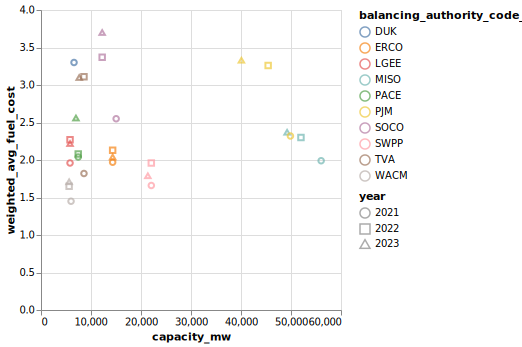

In [5]:
alt.Chart(yearly_coal_data_btu.query("capacity_mw >= 5000")).mark_point().encode(
    x="capacity_mw",
    y="weighted_avg_fuel_cost",
    shape="year:N",
    color="balancing_authority_code_eia",
    tooltip=["balancing_authority_code_eia", "year", "fraction_gen_null_fuel_cost", "weighted_avg_fuel_cost"]
)